<a href="https://colab.research.google.com/github/tswizzle141/Women-Techmakers-Kuala-Lumpur-Colab-Challenge/blob/master/DeepDream_Image_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DeepDream over-interprets and enhances the patterns it sees from an image. 

Forwarding an image through the network, then calculating the gradient of the image with respect to the activations of a particular layer; then modified to increase these activations, enhancing the patterns, resulting in a dream-like image.

# Import Libraries

In [0]:
import numpy as np
import matplotlib
import tensorflow as tf
import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

# Load Image

In [0]:
#Choose an image to dream-ify
url = "https://www.vintagewallpapers.be/wp-content/uploads/2014/02/pink-flower-wallpaper-2.jpg"

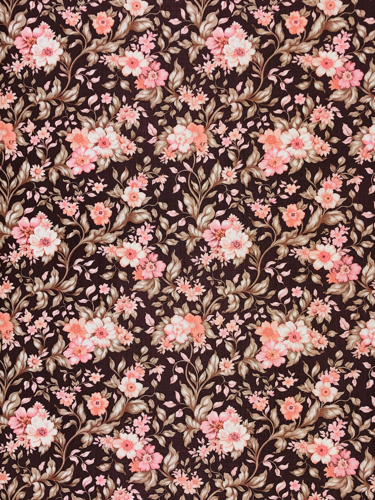

In [82]:
#Download image then convert into array
def download(url, max_dim=None):
  name = url.split('/')[-1] #starts from end of the string with maxsplit option, get the last part, stop number of splits
  img_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(img_path)
  if(max_dim):
    img.thumbnail((max_dim, max_dim))
    '''
    Image.thumbnail() makes image into a thumbnail. 
    Modifying the image to contain a thumbnail version of itself, no larger than the given size. 
    Calculating an appropriate thumbnail size to preserve the aspect of the image and finally resizing the image.
    '''
  return np.array(img)

#Normalize image
'''
Eliminate the unwanted effects in the plot and to produce a smooth pattern where we can see the proper change
'''
def deprocess(img):
  img = 255*(img+1.0)/2.0
  return tf.cast(img, tf.uint8) #Casts a tensor to a new type

#Display image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

#Downsizing the image
orig_img = download(url, max_dim=500)
show(orig_img)

# Prepare feature extraction model

In [0]:
'''
The idea in DeepDream is to choose a layer (or layers) and maximize the "loss" in a way that the image increasingly "excites" the layers.
'''
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [0]:
#Maximize the activation of layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

#Creat the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

# Calculate loss

In [0]:
def cal_loss(img, model):
  #Pass forward the image through the model to retrive the activation
  #Convert image into a batch of size 1

  img_batch = tf.expand_dims(img, axis=0) #Returns a tensor with an additional dimension inserted at index axis
  layer_activations = model(img_batch)
  if (len(layer_activations)==1):
    layer_activations=[layer_activations]

  losses =[]
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)
  return tf.reduce_sum(losses)

# Gradient ascent

In [0]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
          tf.TensorSpec(shape=[None,None,3], dtype=tf.float32), #Describes a tf.Tensor
          tf.TensorSpec(shape=[], dtype=tf.int32),
          tf.TensorSpec(shape=[], dtype=tf.float32),
      )
  )

  def __call__(self, img, steps, step_size):
    print("Tracing")
    loss = tf.constant(0.0)
    for n in tf.range(steps):
      with tf.GradientTape() as tape:
        tape.watch(img)
        loss = cal_loss(img, self.model)

      gradients = tape.gradient(loss, img)
      gradients /= tf.math.reduce_std(gradients) + 1e-8

      img += gradients*step_size
      img = tf.clip_by_value(img, -1, 1)
    return loss, img

In [0]:
deepdream = DeepDream(dream_model)

# Main Loop

In [0]:
def run_dd(img, steps=100, step_size=0.01):
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while(steps_remaining):
    if(steps_remaining>100):
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print("Step {}, Loss: {}".format(step, loss))

  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)
  return result

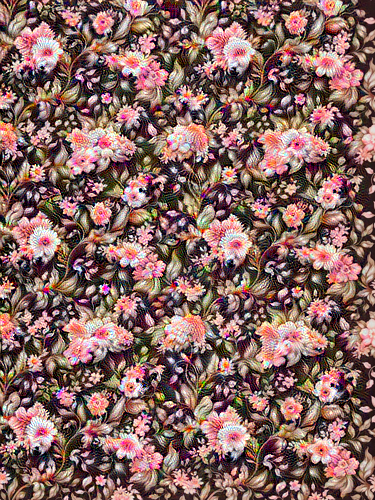

In [89]:
dream_image = run_dd(img=orig_img, steps=100, step_size=0.01)